本章涵盖以下内容：

+ **计算训练集和验证集的损失，以评估训练过程中大型语言模型生成文本的质量**
+ **实现训练函数并预训练大语言模型**
+ **保存和加载模型权重以便继续训练大语言模型**
+ **从OpenAI加载预训练权重**


-----


- [5.1 生成式文本模型的评估](#51-生成式文本模型的评估)
  - [5.1.1 使用 GPT 生成文本](#511-使用-gpt-生成文本)
  - [5.1.2 文本生成损失的计算](#512-文本生成损失的计算)
  - [5.1.3 计算训练集和验证集的损失](#513-计算训练集和验证集的损失)
- [5.2 训练 LLM](#52-训练-llm)
- [5.3 通过解码策略控制生成结果的随机性](#53-通过解码策略控制生成结果的随机性)
  - [5.3.1 Temperature scaling](#531-temperature-scaling)
  - [5.3.2 Top-k 采样](#532-top-k-采样)
  - [5.3.3 对文本生成函数进行调整](#533-对文本生成函数进行调整)
- [5.4 在 PyTorch 中加载和保存模型权重](#54-在-pytorch-中加载和保存模型权重)
- [5.5 从 OpenAI 加载预训练权重](#55-从-openai-加载预训练权重)
- [5.6 本章摘要](#56-本章摘要)



-----



在之前的章节中，我们实现了数据采样、注意力机制，并编写了 LLM 的架构。本章的核心是实现训练函数并对 LLM 进行预训练，详见图 5.1。

<img src="../images/chapter5/figure5.1.png" width="75%" />

如图5.1所示，我们将继续学习基本的模型评估技术，以衡量生成文本的质量，这对于在训练过程中优化 LLM 是非常必要的。此外，我们将讨论如何加载预训练权重，以便为接下来的微调提供坚实的基础。

> [!NOTE]
>
> **权重参数**
>
> 在大语言模型（LLM）和其他深度学习模型中，权重指的是可以通过训练过程调整的参数，通常也被称为权重参数或直接称为参数。在 PyTorch 等框架中，这些权重通常存储在各层（如线性层）中，举例来说，我们在第 3 章实现的多头注意力模块和第 4 章实现的GPT模型中就使用了线性层。在初始化一个层（例如，`new_layer = torch.nn.Linear(...)`）后，我们可以通过`.weight`属性访问其权重，例如`new_layer.weight`。此外，出于便利性，PyTorch还允许通过`model.parameters()`方法直接访问模型的所有可训练参数，包括权重和偏置，我们将在后续实现模型训练时使用该方法。


## 5.1 生成式文本模型的评估

本章开篇，我们将基于上一章的代码设置 LLM 进行文本生成，并讨论如何对生成文本质量进行评估的基本方法。而本章剩余部分的内容请参考图5.2。

<img src="../images/chapter5/figure5.2.png" width="75%" />

如图 5.2 所示，接下来的小节我们首先简要回顾上一章末尾的文本生成过程，然后深入探讨文本评估及训练和验证损失的计算方法。



### 5.1.1 使用 GPT 生成文本

在本节中，我们会先通过对 LLM 的设置简要回顾一下第四章中实现的文本生成过程。在开始这项工作之前，我们首先使用第 4 章中的 GPTModel 类和 GPT_CONFIG_124M 配置字典初始化 GPT 模型，以便在后续章节对其进行评估和训练：


In [5]:
import torch
from previous_chapters import GPTModel
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

#A 我们将上下文长度从1024个token缩短到256个token
#B 将 dropout 设置为 0 是一种常见的做法

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

在之前定义的 GPT_CONFIG_124M 配置字典中，我们唯一的调整是将上下文长度（context_length）减少到 256 个 token。此项调整降低了模型训练的计算需求，使得可以在普通笔记本电脑上进行训练。

参数量为 1.24 亿的 GPT-2 模型最初被配置为可处理最多 1024 个 token。本章结束时，我们将更新上下文大小设置，并加载预训练权重，使模型能够支持 1024-token 的上下文长度。

我们通过前一章节中介绍的 generate_text_simple 函数来使用 GPTmodel 实例，同时引入了两个实用函数：text_to_token_ids 和token_ids_to_text。这些函数简化了文本与 token 表示之间的转换，本章中我们将多次使用这种技术。图 5.3 可以帮助我们更清楚地理解这一过程。

<img src="../images/chapter5/figure5.3.png" width="75%" />

图 5.3 展示了使用 GPT 模型生成文本的三个主要步骤。首先，分词器将输入文本转换为一系列 token ID（在第 2 章中已有讨论）。然后，模型接收这些 token ID 并生成对应的 logits（即词汇表中每个 token 的概率分布，具体见第 4 章）。最后，将 logits 转换回 token ID，分词器将其解码为可读的文本，完成从文本输入到文本输出的循环。

我们通过代码来实现上述过程：

In [6]:
# Listing 5.1 Utility functions for text to token ID conversion
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


执行代码，模型生成的文本如下：

```
Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren
```

从输出可以看出，模型尚未生成连贯的文本，因为它还没有经过训练。为了定义文本的‘连贯性’或‘高质量’，我们需要实现一种数值方法来评估生成的内容。这一方法将帮助我们在训练过程中监督并提升模型的性能。

接下来将介绍如何计算生成内容的损失度量，该损失值会作为训练进展和效果的指示器。此外，在后续关于微调 LLM 的章节中，我们将探讨更多评估模型质量的方法。


### 5.1.2 文本生成损失的计算

本节将探讨如何通过计算‘文本生成损失’来数值化评估训练过程中生成的文本质量。在通过一个实际示例逐步讲解这一主题之前，先简要回顾第 2 章的数据加载方式以及第 4 章的`generate_text_simple`函数如何生成文本。

图 5.4 展示了从输入文本到 LLM 生成文本的整体流程，该流程通过五个步骤实现。

<img src="../images/chapter5/figure5.4.png" width="75%" />

图 5.4 展示了第 4 章中`generate_text_simple`函数内部的本生成过程。在后续章节中计算生成文本的质量损失之前，我们需要先执行这些初始步骤。

为了便于在一页中展示图像，我们图中的示例仅使用了包含 7 个 token 的小型词汇表。然而，GPTModel 实际上使用了包含 50,257 个 token 的大型词汇表，因此在接下来的代码中，token ID 的范围为 0 到 50,256，而不是图示中的 0 到 6。

此外，图 5.4 为了简洁仅展示了一个文本示例 'every effort moves'。在接下来的代码示例中，我们将实现图 5.4 中的步骤，并使用两个输入示例 'every effort moves' 和 'I really like' 作为 GPT 模型的输入。

考虑两个输入样本，它们已经被转换为 token ID，对应图 5.4 中的步骤 1：


In [7]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]

需要注意的是，目标值中展示的是输入数据向前偏移了一个位置。我们在第 2 章实现数据加载器时已介绍过这一概念。这种偏移策略对于教会模型预测序列中的下一个 token 至关重要。

接着我们将两个输入示例（每个示例样本包含三个 token）输入模型以计算它们的 logit 向量，再应用 Softmax 函数将这些 logit 值转换为概率得分，这对应于图 5.4 中的步骤 2：


In [8]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


生成的概率得分张量（probas）的维度如下：

```
torch.Size([2, 3, 50257])
```

第一个数字 2 表示输入中的两个样本（行），即批次大小。第二个数字 3 表示每个样本包含的 token 数量。最后一个数字表示嵌入维度的大小，通常由词汇表大小决定，前面章节已讨论。

通过 softmax 函数将 logits 转换为概率后，第 4 章的 generate_text_simple 函数会将概率得分进一步转换回文本，这一过程在图 5.4 的步骤 3 到步骤 5 中进行了展示。

接下来，通过对概率得分应用 `argmax` 函数，可以得到对应的 token ID（实现步骤 3 和 步骤 4）：


In [9]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n",token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


假设我们有 2 个输入样本，每个样本包含 3 个 token。在对概率得分应用 argmax 函数后（对应图 5.4 的第 3 步），会得到 2 组输出，每组包含 3 个预测的 token ID：

```
Token IDs:
tensor([[[16657], # First batch
        [ 339],
        [42826]],

       [[49906],  # Second batch
        [29669],
        [41751]]])
```

最后，步骤 5 将 token ID 转换回文本：


In [10]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
#When we decode these tokens, we find that these output tokens are quite different from the target tokens we want the model to generate:

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


可以看到，模型生成的文本与目标文本不同，因为它尚未经过训练。接下来，我们将通过‘损失’来数值化评估模型生成文本的质量（详见图 5.5）。这不仅有助于衡量生成文本的质量，还为实现训练函数提供了基础，训练函数主要通过更新模型权重来改善生成文本的质量。

<img src="../images/chapter5/figure5.5.png" width="75%" />

文本评估过程的一部分（如图 5.5 所示）是衡量生成的 token 与正确预测目标之间的差距。本章后面实现的训练函数将利用这些信息来调整模型权重，使生成的文本更接近（或理想情况下完全匹配）目标文本。

换句话说，模型训练的目标是提高正确目标 token ID 所在位置的 softmax 概率，如图 5.6 所示。接下来的部分中，我们还会将该 softmax 概率作为评价指标，用于对模型生成的输出进行数值化评估：正确位置上的概率越高，模型效果越好。

<img src="../images/chapter5/figure5.6.png" width="75%" />

请注意，图 5.6 使用了一个包含 7 个 token 的简化词汇表，以便所有内容可以在一张图中展示。这意味着 softmax 的初始随机值会在 1/7 左右（约 0.14）。

然而，我们为 GPT-2 模型使用的词汇表包含 50,257 个 token，因此每个 token 的初始概率大约只有 0.00002（即 1/50,257）。

对于这两个输入文本，我们可以通过以下代码打印与目标 token 对应的初始 softmax 概率得分：


In [11]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])


每个批次中 3 个目标 token ID 的概率如下：

```
Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
```

训练 LLM 的目标就是最大化这些概率值，使其尽量接近 1。这样可以确保 LLM 始终选择目标 token —— 即句中的下一个词，作为生成的下一个 token。

> [!NOTE]
>
> **反向传播**
>
> 如何最大化目标 token 的 softmax 概率值？整体思路是通过更新模型权重，使模型在生成目标 token 时输出更高的概率值。权重更新通过一种称为反向传播的过程来实现，这是一种训练深度神经网络的标准技术（关于反向传播和模型训练的更多细节可见附录 A 的 A.3 至 A.7 节）。
>
> 反向传播需要一个损失函数，该函数用于计算模型预测输出与实际目标输出之间的差异（此处指与目标 token ID 对应的概率）。这个损失函数用于衡量模型预测与目标值的偏差程度。

在本节剩余内容中，我们将针对`target_probas_1`和`target_probas_2`的概率得分计算损失。图 5.7 展示了主要步骤。

<img src="../images/chapter5/figure5.7.png" width="75%" />

由于我们已经完成了图 5.7 中列出的步骤 1-3，得到了 `target_probas_1` 和 `target_probas_2`，现在进行第 4 步，对这些概率得分取对数：


In [12]:
log_probas =torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log-probabilities:", log_probas)

Log-probabilities: tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])


计算结果如下：

```
tensor([ -9.5042, -10.3796, -11.3677, -11.4798, -9.7764, -12.2561])
```

在数学优化中，处理概率得分的对数比直接处理概率得分更为简便。该主题超出本书的讨论范围，但我在一个讲座中对此进行了详细讲解，链接位于附录 B 的参考部分。
> [!TIP]
>
> **个人思考：** 在继续接下来的计算之前，我们首先来探讨一下，对数在损失函数的应用中到底有什么作用。
>
> 1. **为什么要用概率的对数**
>
>    在 LLM 中，概率得分通常是小于1的数（例如0.1、0.05等），直接用这些数进行计算和优化可能会面临一些问题。比如，如果多个概率相乘，结果会变得非常小，甚至接近0。这种情况称为“数值下溢”（Numerical Underflow），可能导致计算不稳定。
>
>    假设我们有三个概率值，分别为0.2、0.1和0.05。如果我们计算这些值的乘积，结果是：
>
>    $$0.2×0.1×0.05=0.001$$
>
>    这个值非常小，尤其在深度学习或概率模型中，我们通常会有成千上万个概率需要相乘，这样会导致最终的乘积接近0甚至为0，造成数值计算的不稳定性。
>
>    如果我们对这些概率值取对数，然后相加，而不是直接相乘，我们可以避免这个问题。例如，对这三个值取自然对数（logarithm）后再相加：
>
>    $$ln(0.2)+ln(0.1)+ln(0.05)≈−1.6094+(−2.3026)+(−2.9957)=−6.9077$$
>
>    虽然这个和也是负数，但它不会像直接相乘的结果那样接近于0，避免了数值下溢的问题。**对数的累加性质**允许我们将原本的累乘操作转换为累加，使得计算更加稳定和高效。
>
>
>
> 2. 对数概率在损失函数中的作用**
>
>    GPT模型训练的目标是最大化正确目标 token 的概率，通常，我们会使用交叉熵损失来衡量模型预测与实际目标之间的差异。对于一个目标 token 序列 y=(y1,y2,…,yn)，GPT会生成一个对应的预测概率分布 P(y∣x)，其中 x 是模型的输入。
>
>    **交叉熵损失的公式：**
>
>    在计算交叉熵损失时，我们希望最大化模型分配给每个正确目标token的概率。交叉熵损失的数学公式为：
>
>    $$\text { Loss }=-\sum_{t=1}^{T} \ln P\left(y_{t} \mid x, \theta\right)$$
>
>    其中：
>
>    + T 是序列长度
>    + y<sub>t</sub> 是在位置 ttt 上的目标token
>    + P(y<sub>t</sub>∣x,θ) 是模型在参数 θ 下对目标token y<sub>t</sub>  的条件概率
>
>    在公式中，对每个token的概率 P(y<sub>t</sub>∣x,θ)  取对数，将乘积形式的联合概率转换为求和形式，有助于避免数值下溢，同时简化优化过程。


接下来，通过计算平均值将这些对数概率合并为一个评分（参见图 5.7 的第 5 步）：

In [13]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.5722)


由此生成的平均对数概率评分如下：

```
tensor(-10.5722)
```

训练的目标就是通过更新模型权重，使平均对数概率尽可能接近 0（将在 5.2 节中实现）。

然而，在深度学习中，常见做法并不是直接将平均对数概率推向 0，而是通过将负平均对数概率降低至 0 来实现。负平均对数概率就是平均对数概率乘以 -1，这与图 5.7 的第 6 步相对应：


In [14]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.5722)


结算的结果为：`tensor(10.5722)`。

这种将负值 -10.5722 转化为正值 10.5722 的操作在深度学习中称为交叉熵损失。

在这里，PyTorch 非常实用，因为它内置的 cross_entropy 函数已经自动处理了图 5.7 中的 6 个步骤。

> [!NOTE]
>
> **交叉熵损失**
>
> 本质上，交叉熵损失是在机器学习和深度学习中一种常用的度量方法，用于衡量两个概率分布之间的差异——通常是标签的真实分布（此处为数据集中的 token）和模型的预测分布（例如，LLM 生成的 token 概率）。
>
> 在机器学习，特别是 PyTorch 等框架中，cross_entropy 函数用于计算离散输出的损失，与模型生成的 token 概率下的目标 token 的负平均对数概率类似。因此，cross entropy 和负平均对数概率这两个术语在计算上有关联，实践中经常互换使用。

在应用交叉熵函数之前，我们先简要回顾一下 logits 和目标张量的形状：


In [15]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


可以看到，logits 是个三维张量（批量大小、token 数量和词汇表大小）。而 targets 是个二维张量（批量大小和 token 数量）。

在 PyTorch 中使用交叉熵损失函数时，我们需要将这些张量展平，以便在批量维度上进行合并：

In [16]:
logits_flat =logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Logits flat shape:", logits_flat.shape)
print("Targets flat shape:", targets_flat.shape)

Logits flat shape: torch.Size([6, 50257])
Targets flat shape: torch.Size([6])


得到的张量维度如下：

```
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
```

请记住，targets 是希望 LLM 生成的目标 token ID，而 logits 包含了在进入 softmax 函数之前的模型原始输出。

我们之前的实现是先应用 Softmax 函数，再选择目标 token ID 对应的概率分数，计算负的平均对数概率。而在 PyTorch 中，`cross_entropy` 函数能够自动完成所有这些步骤：

In [17]:
loss =torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.5722)


计算得到的损失值与之前手动执行图 5.7 中各个步骤时获得的结果相同：

```
tensor(10.7940)
```

> [!NOTE]
>
> **Perplexity**
>
> `Perplexity` 是一种经常与交叉熵损失一起使用的指标，用于评估语言建模等任务中的模型表现。它能够以更具可解释性的方式，帮助理解模型在预测下一个 token 时的不确定性。
>
> `Perplexity` 常用于衡量模型预测的概率分布与数据集中词的实际分布的接近程度。类似于损失函数，`Perplexity`的值越低，表示模型预测越接近真实分布。
>
> `Perplexity`可通过 `perplexity = torch.exp(loss)` 计算，对先前计算的损失值应用此公式将返回 `tensor(48725.8203)`。
>
> `Perplexity`通常比原始损失值更具可解释性，因为它表示了模型在每一步生成中，对有效词汇量的不确定程度。在这个例子中，`Perplexity`可以理解为模型在词汇表中的 47,678 个单词或 token 中，不确定该选择哪个作为下一个生成的 token。

在本节中，我们对两个小文本输入进行了损失计算，以便更直观地说明损失函数的计算过程。下一节将把损失计算应用于整个训练集和验证集。


### 5.1.3 计算训练集和验证集的损失

在本节中，我们首先准备训练和验证数据集，以用于后续 LLM 的训练。接着，我们计算训练集和验证集的交叉熵（如图 5.8 所示），这是模型训练过程中的重要组成部分。

<img src="../images/chapter5/figure5.8.png" width="75%" />

为了计算训练集和验证集上的损失（如图 5.8 所示），我们使用了一个非常小的文本数据集，即伊迪丝·华顿的短篇小说《判决》，我们在第 2 章中已对此文本进行过处理。选择公共领域的文本可以避免任何关于使用权的担忧。此外，我们选择小数据集的原因在于，它允许代码示例在普通笔记本电脑上运行，即使没有高端 GPU 也能在几分钟内完成，这对于教学尤为有利。

感兴趣的读者可以使用本书的配套代码，准备一个包含超过 60,000 本 Project Gutenberg 公有领域书籍的大规模数据集，并在此数据集上训练 LLM（详情请见附录 D）。

> [!NOTE]
>
> **预训练 LLM 的成本**
>
> 为了更好地理解项目的规模，以一个相对受欢迎的开源 LLM - 70 亿参数的 Llama 2 模型的训练为例。该模型的训练在昂贵的 A100 GPU 上共耗费了 184,320 个小时，处理了 2 万亿个 token。在撰写本文时，AWS 上 8 张 A100 卡的云服务器每小时费用约为 30 美元。粗略估算，训练这样一个 LLM 的总成本约为 69 万美元（计算方法为 184,320 小时除以 8，再乘以 30 美元）。

以下代码用于加载我们在第 2 章中使用的《判决》短篇小说：


In [18]:
file_path = "../data/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

加载数据集后，我们可以查看其中的字符数和 token 数：

In [19]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Total characters:", total_characters)
print("Total tokens:", total_tokens)

Total characters: 20479
Total tokens: 5145


输出如下：

```
Characters: 20479
Tokens: 5145
```

仅有 5,145 个 token，看起来似乎不足以训练一个 LLM，但正如前面提到的，这仅用于教学演示，因此我们可以将代码的运行时间控制在几分钟，而不是几周。此外，在本章最后，我们将把 OpenAI 的预训练权重加载到我们的 GPTModel 代码中。

接下来，我们将数据集划分为训练集和验证集，并使用第二章的数据加载器为 LLM 训练准备需输入的批量数据。图 5.9 展示了该过程。

<img src="../images/chapter5/figure5.9.png" width="75%" />

出于可视化的需要，图 5.9 将最大长度设置为 6。然而，在实际数据加载器中，我们会将最大长度设置为 LLM 支持的 256 个 token 的上下文长度，使得模型在训练时可以看到更长的文本。

> [!NOTE]
>
> **处理变长输入的训练**
>
> 在训练模型时，我们可以使用大小相似的数据块来保证训练过程的简便和高效。然而，在实践中，使用变长的输入进行训练往往有助于提升 LLM 的泛化能力，使其在应用时能够适应不同类型的输入。

为了实现图 5.9 中的数据划分与加载，我们首先定义一个 `train_ratio`，用于将 90% 的数据用于训练，剩余 10% 用于在训练期间进行模型评估：


In [20]:
train_ratio = 0.90
split_idx = int(len(text_data) * train_ratio)
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

现在可以使用 train_data 和 val_data 子集，复用第 2 章中的 create_dataloader_v1 代码来创建相应的数据加载器:

In [21]:
from previous_chapters import create_dataloader_v1
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

在前面的代码示例中，由于数据集较小，我们使用了较小的批量以降低计算资源的消耗。实际训练 LLM 时，批量大小达到 1,024 或更高并不少见。

为了确认数据加载器是否正确创建，可以通过遍历这些数据加载器来检查：

In [22]:
print("Train data:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nVal data:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train data:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Val data:
torch.Size([2, 256]) torch.Size([2, 256])


执行代码，可以看到以下输出：

```
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
```

可以看到，训练集中共有 9 个批次，每批包含 2 个样本，每个样本有 256 个 token。由于只分配了 10% 的数据用于验证，因此验证集中只有 1 个批次，包含 2 个样本。

和我们的预期一致，输入数据（x）和目标数据（y）的形状相同（即批次大小 × 每批的 token 数量），因为目标数据是将输入数据整体向后偏移一个位置得到的，正如第 2 章讨论的那样。

接下来我们实现一个工具函数，用于计算由训练和验证加载器返回的批量数据的交叉熵损失：


In [23]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)       #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

#A 将数据传输到指定设备（如 GPU），使数据能够在 GPU 上处理。

现在我们可以使用 `calc_loss_batch` 工具函数来实现 `calc_loss_loader` 函数，`calc_loss_loader` 将用于计算指定数据加载器中的指定数据批次的损失:

In [24]:
# Listing 5.2 Function to compute the training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)                                    #A
    else:
        num_batches = min(num_batches, len(data_loader))                  #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     #C
        else:
            break
    return total_loss / num_batches                                       #D


#A 如果没有指定批次数，将自动遍历所有批次
#B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
#C 每个批次的损失求和
#D 对所有批次的损失取平均值

默认情况下，`calc_loss_batch` 函数会遍历 `data loader` 中的所有批次数据，将每批次的损失累加到 `total_loss` 中，并计算所有批次的平均损失。作为替代方案，我们可以通过 `num_batches` 参数指定更少的批次数，以加快模型训练过程中的评估速度。

现在让我们看看如何将 `calc_loss_batch` 函数应用到训练集和验证集加载器中：

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.981106758117676


损失值如下：
```
Training loss: 10.98758347829183
Validation loss: 10.98110580444336
```

模型未经过训练，因此损失值较高。相比之下，如果模型学会按训练集和验证集中的真实顺序生成下一个 token，损失值就会接近 0。

现在我们已经有了评估生成文本质量的方法，接下来我们将训练 LLM 以减少损失，从而提升文本生成的效果，如图 5.10 所示。

<img src="../images/chapter5/figure5.10.png" width="75%" />

如图 5.10 所示，下一节将重点讲解 LLM 的预训练过程。在模型训练完成后，将应用不同的文本生成策略，并保存和加载预训练模型的权重。

## 5.2 训练 LLM

在本节中，我们将实现 LLM（基于GPTModel）的预训练代码。我们重点采用一种简单的训练循环方式来保证代码简洁易读（如图 5.11 所示）。不过，有兴趣的读者可以在附录 D 中了解更多高级技术，包括学习率预热、余弦退火和梯度裁剪等，以进一步完善训练循环。

<img src="../images/chapter5/figure5.11.png" width="75%" />

图 5.11 中的流程图展示了一个典型的 PyTorch 神经网络训练流程，我们用它来训练大语言模型（LLM）。流程概述了 8 个步骤，从迭代各个 epoch 开始，处理批次数据、重置和计算梯度、更新权重，最后进行监控步骤如打印损失和生成文本样本。如果你对使用 PyTorch 如何训练深度神经网络不太熟悉，可以参考附录 A 中的 A.5 至 A.8 节。

我们可以通过以下`train_model_simple`函数来实现这一训练流程：

In [26]:
# Listing 5.3 The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []                        #A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):                                                 #B
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                                                   #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                                         #D
            optimizer.step()                                                        #E
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                                        #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(                                                  #G
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


#A 初始化用于记录损失和已处理 token 数量的列表
#B 开始主训练循环
#C 重置上一批次的损失梯度
#D 计算损失梯度
#E 使用损失梯度更新模型权重
#F 可选的评估步骤
#G 每个 epoch 结束后打印示例文本

注意，我们刚刚创建的 `train_model_simple` 函数使用了两个尚未定义的函数：`evaluate_model` 和 `generate_and_print_sample`。

`evaluate_model` 函数对应图 5.11 中的步骤 7。该函数会在每次模型更新后打印训练集和验证集的损失，从而帮助我们评估训练是否改进了模型。

更具体地说，`evaluate_model` 函数会在训练集和验证集上计算损失，同时确保模型处于评估模式，并在计算损失时禁用梯度跟踪和 dropout

In [27]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

与 `evaluate_model` 类似，`generate_and_print_sample` 是一个工具函数，用于跟踪模型在训练过程中是否有改进。具体来说，`generate_and_print_sample` 函数接收一个文本片段（`start_context`）作为输入，将其转换为 token ID，并传递给 LLM，借助之前的 `generate_text_simple` 函数生成文本示例：

In [28]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size =model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()

`evaluate_model`函数通过数值来评估模型的训练进展，而`generate_and_print_sample`函数则通过生成的实际文本示例，帮助我们在训练过程中判断模型的能力。

> [!NOTE]
>
> **ADAMW**
>
> Adam 优化器在深度神经网络训练中非常流行。然而在我们的训练循环中，我们选择了 AdamW 优化器。AdamW 是 Adam 的一种变体，通过改进权重衰减方式，帮助减少模型复杂度，并通过惩罚较大的权重来防止过拟合。这样的调整使得 AdamW 能更有效地实现正则化，并提升模型的泛化能力，因此被广泛应用于大语言模型的训练中。

让我们通过训练一个 GPTModel 实例来实际操作看看，训练 10 个 epoch，使用 AdamW 优化器和之前定义的`train_model_simple`函数：

In [29]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.897, Val loss 9.933
Ep 1 (Step 000005): Train loss 7.917, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.847, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.997, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.659, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.363, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.010, Val loss 6.278
Ep 4 (Step 000035): Train loss 2.549, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.834, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

执行 `training_model_simple` 函数将开始训练过程，在 MacBook Air 或类似的笔记本电脑上完成约需 5 分钟。执行过程中打印的输出如下所示：

```
Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and,
and, and, and, and, and, and, and, and, and,, and, and,
[...] Results are truncated to save space                 #A
Ep 9 (Step 000080): Train loss 0.541, Val loss 6.393
Every effort moves you?" "Yes--quite insensible to the irony. She wanted him
vindicated--and by me!" He laughed again, and threw back the window-curtains, I had the
donkey. "There were days when I
Ep 10 (Step 000085): Train loss 0.391, Val loss 6.452
Every effort moves you know," was one of the axioms he laid down across the Sevres and
silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run
over from Monte Carlo; and Mrs. Gis

#A 中间结果被省略以节省空间
```

根据训练过程中的输出结果，训练损失显著下降，从 9.781 降到 0.391，模型的语言能力大幅提升。在训练初期，模型仅能在起始上下文后添加逗号（如“Every effort moves you,,,,,,,,,,,,”）或重复单词“and”。而在训练结束时，模型能够生成符合语法的文本。

与训练集损失类似，我们可以看到验证集损失在开始时较高（9.933），随后在训练过程中下降。但它始终未能像训练集损失那样低，在第 10 个 epoch 后保持在 6.452。

在更详细地讨论验证集损失之前，我们先创建一个简单的图表，将训练集和验证集损失并排展示：

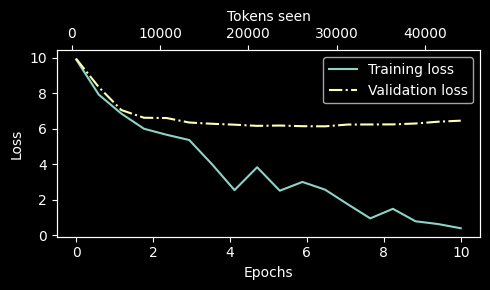

In [30]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

#A 创建与 y 轴共用的第二个 x 轴
#B 用于对齐刻度的隐藏图形

生成的训练损失和验证损失图表如图 5.12 所示。

<img src="../images/chapter5/figure5.12.png" width="75%" />

如图 5.12 所示，训练损失和验证损失在第一个 epoch 开始时都有所改善。然而，从第二个 epoch 之后，损失开始出现分歧。验证损失远高于训练损失，这表明模型在训练数据上出现了过拟合。我们可以通过搜索生成的文本片段（例如“The Verdict”文件中的片段：“quite insensible to the irony”）来确认模型逐词记住了训练数据。

这种记忆现象是预料之中的，因为我们使用了一个非常小的训练数据集，并且对模型进行了多轮训练。通常，我们会在更大的数据集上训练模型，并且只需训练一个 epoch 即可。

> [!TIP]
>
> **个人思考：** 让我们基于 LLM 的原理来探讨一下为什么在一个较小的数据集上进行多轮训练，容易产生过拟合的现象？
>
> 1. **模型容量与数据集大小的匹配问题**
>    + 大语言模型具有极高的参数容量，通常包含数百万甚至数十亿个参数。如此巨大的参数空间可以高度灵活地适应数据，使得模型能够“记住”每个样本的具体特征
>    + 当数据集很小时，模型没有足够的多样性去学习广泛的模式，而是倾向于学习每个数据点的细节。经过多轮训练，模型会逐渐“记住”小数据集中每个样本的特征，从而导致过拟合。
> 2. **多轮训练导致对数据集细节的过度学习**
>    + 多轮训练意味着模型会反复接触相同的数据。这种重复使得模型逐渐适应数据集的特定模式，而不是学习一般化的规律。
>    + 每次训练迭代都会使模型在数据集上拟合得更好，因此在训练数据上损失逐渐减小，但由于缺少新的数据，模型无法学习到通用模式，只会进一步记住训练样本的细节。
> 3. **数据集的多样性不足**
>    + 小数据集通常不能代表广泛的语言特征和分布，缺乏多样性。模型在小数据集上多轮训练，基本上是在有限的样本范围内形成模式，导致它对特定的训练样本依赖性过强。
>    + 这种缺乏多样性的训练会使模型偏向训练数据的分布，难以适应实际应用中广泛的输入数据。
> 4. **过拟合与模型泛化能力的矛盾**
>    + 过拟合本质上是模型在训练数据上的表现优异，但在未见过的数据上表现较差。大语言模型的训练目标是提高其泛化能力，即能在更广泛的分布上生成有意义的文本。
>    + 当数据集非常小且多轮训练时，模型会对数据的细节和噪声进行过度拟合，这会导致模型在测试数据或实际应用中表现不佳，因为它无法应对新的、不同分布的输入。
>
>


在接下来的部分（如图 5.13 所示），我们将探讨 LLM 使用的采样方法，这些方法可以减轻记忆效应，从而生成更具新意的文本。

<img src="../images/chapter5/figure5.13.png" width="75%" />

如图 5.13 所示，下一节将介绍适用于 LLM 的文本生成策略，以减少训练数据的记忆倾向，提升 LLM 生成文本的原创性。之后我们还会讨论权重的加载与保存，以及从 OpenAI 的 GPT 模型加载预训练权重。

## 5.3 通过解码策略控制生成结果的随机性

本节将介绍文本生成策略（也称为解码策略），用于生成更具原创性的文本。首先，我们将简要回顾前一章中的`generate_text_simple`函数，该函数已在本章前面用于生成和打印样本。然后，我们会讲解两种改进方法：`temperature scaling`和 `top-k 采样`。

首先，我们将模型从 GPU 转移回 CPU，因为相对较小的模型在推理时不需要使用 GPU。另外，在训练结束后，我们会将模型切换到评估模式，以关闭 dropout 等随机组件：

In [31]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

接下来，将 GPTModel 的实例（model）传入 generate_text_simple 函数，该函数使用 LLM 一次生成一个 token：

In [32]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


执行代码，会生成以下文本：

```
Output text:
Every effort moves you know," was one of the axioms he laid down across the Sevres and
silver of an exquisitely appointed lun
```

如 5.1.2 节中所述，在生成过程中的每一步，都会选取词汇表中概率得分最高的 token 作为生成的 token。

接下来介绍两种控制生成文本随机性和多样性的方法：`temperature scaling`和`top-k sampling`。


### 5.3.1 Temperature scaling

本节将介绍`temperature scaling`，这是一种在生成下一个词时加入概率选择的技术。

之前，在 `generate_text_simple` 函数中，我们总是用 `torch.argmax` 选择概率最高的 token 作为下一个词，这也叫做贪心解码。为了生成更加多样化的文本，可以将 `argmax` 替换为一种从概率分布中进行采样的函数（这里，概率分布是指模型在每一步为每个词汇生成的概率得分）。

为了用具体的例子说明概率采样，我们将简要讨论下一词生成过程，并用一个非常小的词汇表来进行示例演示：

In [33]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

接下来，假设给 LLM 一个初始上下文‘every effort moves you’，并生成下一个 token 的 logits 分数（如下所示）：

In [34]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

接着在 `generate_text_simple` 函数中，通过 softmax 函数将 logits 转化为概率，并通过 argmax 函数得到生成的 token 的 ID，最后通过逆词汇表将其映射回文本（可以回顾上一章）：

In [35]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


由于第四个位置的 logit 值最大，相应地，Softmax 归一化后的概率分数也在该位置上最大，因此生成的下一个词就是这个位置对应的词。

为了实现概率采样过程，现在可以用 PyTorch 中的 multinomial 函数代替 argmax：

In [36]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


输出依然是“forward”，这和之前一样。这是为什么？ multinomial 函数根据每个 token 的概率得分来采样下一个 token。换句话说，“forward” 依然是最有可能的 token，因此大多数情况下会被 multinomial 选中，但并不是每次都选中。为了演示这一点，我们可以实现一个函数，重复采样 1000 次：

In [37]:
def print_sample_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sample_ids =torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sample_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sample_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


采样输出结果如下：

```
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
```

从输出结果可以看出，单词‘forward’在生成过程中被采样的次数最多（在 1000 次生成中出现了 582 次），但‘closer’、‘inches’和‘toward’等其他词语也偶尔会被采样到。这意味着，如果在生成函数 generate_and_print_sample 中将 argmax 替换为 multinomial，模型有时会生成类似‘every effort moves you toward’、‘every effort moves you inches’和‘every effort moves you closer’这样的句子，而不是固定生成‘every effort moves you forward’。

我们可以通过一种称为`temperature scaling`的方法进一步控制分布和选择过程，所谓`temperature scaling`，其实就是将 logits 除以一个大于 0 的数：


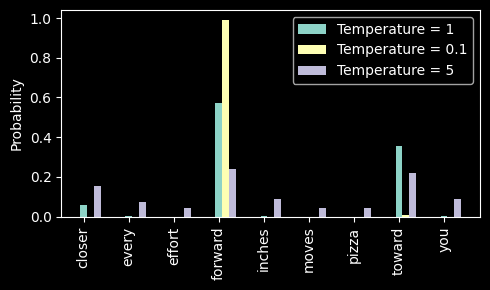

In [38]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]             #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#A 原始、较低和较高置信度

图 5.14 展示了生成的图表:

<img src="../images/chapter5/figure5.14.png" width="75%" />

当 temperature 取 1 时，logits 在传递给 softmax 函数之前会除以 1，计算概率得分。这意味着，temperature 为 1 时相当于不进行任何缩放。在这种情况下，模型将根据原始的 softmax 概率，通过 PyTorch 中的`multinomial`函数来选择 token。

如图 5.14 所示，当 temperature 设置为非常小的值（如 0.1）时，生成的分布会更加尖锐，因此`multinomial`函数几乎总是选择最可能的 token（这里是 ‘forward’），其行为接近 argmax 函数。相反，当 temperature 设置为 5 时，生成的分布更接近均匀分布，其他 token 被选中的频率更高。这种情况下，生成的文本多样性增加，但也更可能出现无意义的内容。例如，temperature 设置为 5 时，模型生成类似 ‘every effort moves you pizza’ 的文本概率大约为 4%。

> [!TIP]
>
> **个人思考：** 为什么 temperature 值非常小时，生成的概率分布会更加尖锐，越大时，概率分布会更加均匀，文中只是说了结论，没有说过程。
>
> **temperature** 参数被引入到 softmax 函数中，用于缩放 logits，从而控制输出的概率分布。当引入 temperature 后，softmax 函数的公式变为：
>
> $$ P\left(x_{i}\right)=\frac{\exp \left(\frac{z_{i}}{T}\right)}{\sum_{j} \exp \left(\frac{z_{j}}{T}\right)} $$
>
> 1. **当 T>1**
>    所有 logits 被除以 T，缩放后，差异变小。由于 exp 函数的敏感性较高，这意味着 logits 值的差异被“压平”，使得最优词的概率降低，而其他次优词的概率提高。输出的概率分布变得更加均匀，再结合multinomial函数，可以使生成结果更加多样化，但同时也降低了生成结果的确定性。
>
> 2. **当 T<1**
>
>    logits 除以 T 后会被放大，差异变得更加显著。softmax 函数会使最高 logit 对应的词语的概率变得更高，其他词语的概率更低。这导致输出的概率分布更加集中，模型更倾向于选择概率最大的词，从而提高了生成结果的确定性。


### 5.3.2 Top-k 采样

在前一节中，我们实现了一种结合`temperature scaling`的概率采样方法来增加生成内容的多样性。我们发现，较高的 temperature 值会使下一词的概率分布更均匀，从而降低模型反复选择最可能词的概率，这样可以生成更多样化的内容，使生成过程探索那些概率较低但可能更有趣和创意的路径。不过，这种方法的一个缺点是，有时会导致生成语法不正确或完全不合逻辑的内容，比如 "every effort moves you pizza"。

在本节中，我们引入了另一种称为`top-k 采样`的概念，当与概率采样和`temperature scaling`结合使用时，可以提升文本生成效果。

在 top-k 采样中，我们可以将采样限制在最有可能的前 k 个 token 内，并通过将其他 token 的概率设为零，将它们排除在选择之外，如图 5.15 所示。

<img src="../images/chapter5/figure5.15.png" width="75%" />

如图 5.15 所示，将所有未选中的 logits 替换为负无穷（-inf），这样在计算 Softmax 时，非 top-k 的 token 的概率为 0，剩下的概率之和为 1。（细心的读者可能记得，我们在第 3 章的因果注意力模块中使用过这种掩码技巧。）

接下来让我们通过代码实现 Figure 5.15 中描述的 top-k 过程，首先选出 logits 值最大的那些 token：


In [39]:
top_k = 3
top_logits, top_pos =torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


```
Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
```
接下来，我们应用 PyTorch 的 where 函数，将非 top-3 的 token 的 logit 值设为负无穷大（-inf）：

In [40]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],   #A
    input=torch.tensor(float('-inf')),              #B
    other=next_token_logits                         #C
)
print(new_logits)

#A 识别出小于 top 3 最小值的 logits
#B 将这些较小的 logits 赋值为负无穷大
#C 保留所有其他 token 的原始 logits

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


执行代码，得到以下用于预测下一个 token 的 logits （在 9 个 token 的词汇表中）：
```
tensor([4.5100, -inf, -inf, 6.7500, -inf, -inf, -inf, 6.2800, -inf])
```

最后，应用 softmax 函数将其转化为下一词的概率分布：

In [41]:
topk_probas =torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


可以看到，通过 top-3 方法得到的结果是三个非零的概率得分：
```
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
```

我们现在可以应用temperature scaling 和multinomial函数来进行概率采样，从这 3 个非零概率得分中选择下一个 token。在下一节中，我们将通过修改文本生成函数来实现此操作。

### 5.3.3 对文本生成函数进行调整
前两节介绍了两种增加 LLM 生成文本多样性的概念：`temperature scaling`和`top-k` 采样。本节中，我们将这两个概念整合并加入到之前用于生成文本的`generate_simple`函数中，从而创建一个新的`generate`函数：

In [42]:
# Listing 5.4 A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):                             #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:                                   #B
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:                                       #C
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:                                                       #D
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:                                      #E
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


#A For循环与之前相同：获取logits，仅关注最后的时间步
#B 在新步骤中，通过top-k采样过滤logits
#C 在新步骤中应用temperature scaling
#D 在未使用temperature scaling时，执行贪婪的下一个token选择
#E 如果遇到序列结束token且指定了eos_id，则提前停止生成

现在来看看这个新的`generate`函数的实际效果：

In [43]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


生成的文本如下:

```
Output text:
Every effort moves you stand to work on surprise, a one of us had gone with random-
```

正如我们所见，当前生成的文本与之前在 5.3 节开头用 generate_simple 函数生成的文本有很大不同（例如那句"Every effort moves you know," was one of the axioms he laid...!"），而后者是模型从训练集中记忆的一段话

## 5.4 在 PyTorch 中加载和保存模型权重

在本章中，我们讨论了如何数值化评估训练进度，以及从零开始预训练 LLM。尽管模型和数据集都相对较小，这次练习依然展示了预训练 LLM 的高昂成本。因此，能够保存 LLM 以避免每次在新会话中使用时都重新训练显得尤为重要。

如图 5.16 的章节概览所示，本节将介绍如何保存和加载预训练模型。然后，在接下来的部分中，我们将从 OpenAI 加载一个更强大的预训练 GPT 模型到我们的 GPTModel 实例中。

<img src="../images/chapter5/figure5.16.png" width="75%" />

幸运的是，保存 PyTorch 模型相对简单。推荐的做法是保存模型的 `state_dict`（状态字典），这是一个字典，用于将模型的每一层映射到其对应的参数上，可以通过 `torch.save` 函数来实现，代码如下所示：

In [44]:
torch.save(model.state_dict(), "model.pth")

在以上代码中，`model.pth`是用于保存 `state_dict` 的文件名。`.pth` 是 PyTorch 文件的惯用扩展名，但实际上也可以使用其他扩展名。

使用 `state_dict` 保存模型权重后，可以将权重加载到新的 GPTModel 模型实例中，具体操作如下：


In [45]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

正如第 4 章所讨论的，dropout 通过在训练过程中随机“丢弃”某些神经元，以防止模型过拟合。然而，在推理阶段，我们不希望随机丢弃网络中学到的任何信息。通过使用 `model.eval()`，模型会切换到推理阶段的评估模式，从而禁用 dropout 层。

如果计划稍后继续预训练模型（例如使用本章之前定义的 `train_model_simple` 函数），那么建议同时保存优化器状态。

AdamW 等自适应优化器会为每个模型参数存储额外信息。AdamW 使用历史数据动态调整每个模型参数的学习率。没有这些信息时，优化器会重置，模型可能无法有效学习，甚至无法正确收敛，进而失去生成连贯文本的能力。可以使用 `torch.save` 保存模型和优化器的状态，方法如下：

In [46]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

接下来，我们可以按以下步骤恢复模型和优化器的状态：首先通过 `torch.load` 加载保存的数据，然后使用 `load_state_dict` 方法恢复状态：

In [47]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 从 OpenAI 加载预训练权重

之前，我们为了教学目的，使用有限的数据集（包含一本短篇小说集）训练了一个小型 GPT-2 模型，这样可以专注于讲解 LLM 的基本原理，而无需耗费大量时间和计算资源。

OpenAI 公开了 GPT-2 模型的权重，使我们不必投入数十万甚至数百万美元自行在大规模语料上重新训练模型。

在本节的余下部分，我们将把这些权重加载到 GPTModel 类中，并利用该模型进行文本生成。这里的权重是指存储在 PyTorch 的 Linear 和 Embedding 层的 `.weight`属性中的权重参数（在训练模型时，我们可以通过`model.parameters() `访问这些权重）。

在后续章节中，我们将复用这些预训练权重，对模型进行微调以用于文本分类任务，并遵循类似 ChatGPT 的指令。

请注意，OpenAI 最初使用 TensorFlow 来保存 GPT-2 的权重，因此在 Python 中加载这些权重需要安装 TensorFlow。另外，以下代码将使用进度条工具 tqdm 来跟踪下载进度，也需要提前安装。

请在终端中执行以下命令来安装所需的库：

```
pip install tensorflow>=2.15.0 tqdm>=4.66
```

由于下载代码篇幅较长，主要是样板代码，因此本章不会浪费篇幅详细讨论。读者可以直接从本章的在线资源库下载 `gpt_download.py` 模块:

In [48]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x20f4fc1aab0>)

接下来，在将此文件下载到本地目录后，建议读者简单查看文件内容，确保文件已正确保存并包含有效的 Python 代码。

我们现在可以从 `gpt_download.py` 文件中导入 `download_and_load_gpt2` 函数，从而将 GPT-2 的架构设置（settings）和权重参数（params）加载到 Python 会话中：

In [49]:
from gpt_download import download_and_load_gpt2
settings, params =download_and_load_gpt2(model_size='124M', models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


```
Executing the proceeding code downloads the following 7 files associated with the 124M
parameter GPT-2 model:
checkpoint: 100%|███████████████████████████| 77.0/77.0 [00:00<00:00, 63.9kiB/s]
encoder.json: 100%|█████████████████████████| 1.04M/1.04M [00:00<00:00, 2.20MiB/s]
hprams.json: 100%|██████████████████████████| 90.0/90.0 [00:00<00:00, 78.3kiB/s]
model.ckpt.data-00000-of-00001: 100%|███████| 498M/498M [01:09<00:00, 7.16MiB/s]
model.ckpt.index: 100%|█████████████████████| 5.21k/5.21k [00:00<00:00, 3.24MiB/s]
model.ckpt.meta: 100%|██████████████████████| 471k/471k [00:00<00:00, 2.46MiB/s]
vocab.bpe: 100%|████████████████████████████| 456k/456k [00:00<00:00, 1.70MiB/s]
```
代码执行完成后，查看 `settings` 和 `params` 的内容：

In [50]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


输出如下：

```
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
```

`settings` 和 `params` 都是 Python 字典。`settings` 字典存储了 LLM 的架构设置，与我们之前手动定义的 `GPT_CONFIG_124M` 设置类似；`params` 字典则包含实际的权重张量。注意，我们只打印了字典的键，因为打印整个权重内容会占用太多屏幕空间。不过，我们可以通过`print(params)` 打印整个字典，或使用特定的字典键选择对应张量进行查看，例如嵌入层的权重：

In [51]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


token 嵌入层的权重如下所示：

```
[[-0.11010301 ... -0.1363697 0.01506208 0.04531523]
 [ 0.04034033 ... 0.08605453 0.00253983 0.04318958]
 [-0.12746179 ... 0.08991534 -0.12972379 -0.08785918]
 ...
 [-0.04453601 ... 0.10435229 0.09783269 -0.06952604]
 [ 0.1860082 ... -0.09625227 0.07847701 -0.02245961]
 [ 0.05135201 ... 0.00704835 0.15519823 0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)
```

我们通过 `download_and_load_gpt2(model_size="124M", ...)` 加载了最小的 GPT-2 模型权重。此外，OpenAI 还提供了更大规模模型的权重，包括 "355M"、"774M" 和 "1558M" 等。尽管模型规模不同，但其整体架构是相同的，如图 5.17 所示。

<img src="../images/chapter5/figure5.17.png" width="75%" />

如图 5.17 所示，不同大小的 GPT-2 模型在总体架构上保持一致，但注意力头和 Transformer 模块等组件的重复次数以及嵌入维度大小有所不同。本章的剩余代码也会兼容这些更大的模型。

在将 GPT-2 模型的权重加载到 Python 后，我们还需要将这些权重从 `settings` 和 `params` 字典转移到 GPTModel 实例中：


In [52]:
# First, we create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

细心的读者可能记得，我们之前设置的 token 长度是 256，但 OpenAI 的原始 GPT-2 模型使用的是 1,024 的 token 长度，因此我们需要相应地更新 NEW_CONFIG:

In [59]:
NEW_CONFIG.update({"context_length": 1024})

此外，OpenAI 在多头注意力模块的线性层中使用了偏置向量，以实现查询（query）、键（key）和值（value）矩阵的计算。偏置向量在现代 LLM 中已不再常用，因为它们对提升模型性能没有帮助，因而不再必要。然而，由于我们使用的是预训练权重，为了保持一致性，仍需启用这些偏置向量：

In [60]:
NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

默认情况下，GPTModel 实例会使用随机权重进行预训练。而使用 OpenAI 的模型权重的最后一步是将 `params` 字典中加载的权重覆盖这些随机权重。

为此，我们首先来定义一个简单的`assign`工具函数，用于检查两个张量或数组（左侧和右侧）的维度或形状是否一致，并将右侧张量作为可训练的 PyTorch 参数返回：

In [62]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

接下来，我们定义一个名为 `load_weights_into_gpt` 的函数，用于将 params 字典中的权重加载到 GPT 模型实例中：

In [63]:
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

在 `load_weights_into_gpt` 函数中，我们需要将 OpenAI 实现中的权重与自定义的 GPTModel 实现进行精确匹配。举个例子，OpenAI 将第一个 Transformer 模块的输出投影层权重存储在 `params["blocks"][0]["attn"]["c_proj"]["w"]` 中。而在我们的实现中，这个权重对应于 `gpt.trf_blocks[b].att.out_proj.weight`，其中 `gpt` 是一个 GPTModel 实例。

在开发 `load_weights_into_gpt` 函数时，由于 OpenAI 的命名规范和我们的略有不同，我们进行了大量的尝试。幸运的是，`assign` 函数会在张量维度不匹配时发出警告。此外，如果这个函数有错误，我们会发现生成的 GPT 模型无法生成连贯的文本，从而识别出问题。

我们暂时不在实际操作中尝试 `load_weights_into_gpt`，而是直接将 OpenAI 模型的权重加载到我们自己的 `GPTModel` 实例 `gpt` 中：


In [64]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

如果模型加载成功，就可以使用之前的 `generate` 函数生成新文本：

In [65]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




生成的文本如下：

```
Output text:
 Every effort moves you toward finding an ideal new way to practice something!
What makes us want to be on top of that?
```

我们可以确认模型权重已正确加载，因为模型能够生成连贯的文本；在这个过程中，哪怕一个小错误都会导致模型生成失败。

在接下来的章节中，我们将进一步使用该预训练模型，并对其进行微调，使其能够进行文本分类和指令执行。


## 5.6 本章摘要

+ 大语言模型在生成文本时，逐个生成 token。
+ 默认情况下，模型通过将输出转换为概率分数，并选择其中概率最高的 token 来生成下一个 token，这种方式称为“贪心解码”。
+ 通过概率采样和`temperature scaling`，可以影响生成文本的多样性和连贯性。
+ 训练集和验证集的损失可以用来评估 LLM 在训练过程中生成文本的质量。
+ 预训练 LLM 的过程就是通过调整模型权重来最小化训练损失。
+ LLM 的训练循环是深度学习中的标准流程，通常使用交叉熵损失和 AdamW 优化器。
+ 在大规模文本数据集上预训练 LLM 非常耗费时间和资源，因此可以加载 OpenAI 提供的开源预训练权重，作为自行预训练模型的替代方案。